In [1]:
import numpy as np
import numpy.polynomial.legendre as leg
import matplotlib.pyplot as plt
from naginterfaces.library import opt, fit
import scipy.optimize as scipy_opt
import scipy
import time

# Polynomial regression using Linear Programming

## Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

## Introduction

We are interested in fitting a polynomial of arbitrary degree to some data where noise and outliers are present.\\


First, define a curve we want to fit:

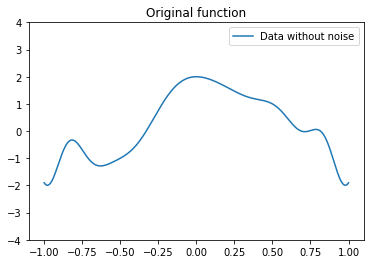

In [2]:
nsamples = 1000
xs = np.linspace(-1,1,nsamples)
ys = xs*np.pi

# data to be fitted
f = np.cos(ys) + np.sin(ys)*np.sin(ys)*np.sin(ys)+np.cos(ys)*np.cos(ys)*np.cos(ys*ys)
    
# Plot the curve
plt.plot(xs,f)
plt.ylim(-4,4)
plt.legend(["Data without noise"])
plt.title('Original function');

Let's now add some noise to create our data points

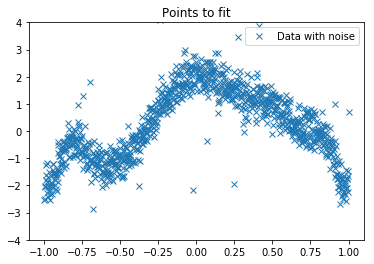

In [3]:
np.random.seed(4484)

# Error vector to be added to the observations 
errs = np.random.normal(0.0,0.4,(nsamples))

# Increase the error significantly on some points to simulate outliers
noutliers = 50
if noutliers > 0:
    outliers = np.floor(np.random.rand(noutliers)*nsamples).astype(np.int)
    errs[outliers] = errs[outliers]*20.0
    
fn = f + errs

# Plot the points
plt.plot(xs,fn, 'x')
plt.ylim(-4,4)
plt.legend(["Data with noise"])
plt.title('Points to fit');

## Problem definition

For a polynomial of degree $k$, the problem is then to find the best set of parameters $(x_0, x_1, ..., x_k)$ so that the errors for all data points $(a_i, b_i)$, $i = 1, m$
\begin{equation*}
    \epsilon_i = x_0 + x_1 a_i + x_2 a_i^2 + ... + x_k a_i^k - b_i
\end{equation*}
is minimal in some sense. In matrix form:
\begin{equation*}
    \min_b ||Ax - b||_l
\end{equation*}
where A is a $k\times m$ Vandermonde matrix

When outliers are present in the data, a classical choice is $l = 1$. This one norm minimization can be easily formulated as an LP problem:
\begin{equation*}
    \min y\\
    \text{s.t. } -y \leq Ax - b \leq y\\
    y \geq 0
\end{equation*}

### Using Scipy
We have a linear programming problem and A is completely dense. Let's reformulate the problem to a standard form and try the Scipy `opt.linprog` routine.
\begin{equation*}
    \min y\\
    \text{s.t. } Ax - y\leq b\\
    -Ax - y \leq -b\\
    y \geq 0
\end{equation*}

In [4]:
def lst_1norm_scipy(A,b,method='simplex'):
    (m,n)=A.shape
    nvars=m+n
    ncons=2*m
    
    first_cons=[i for i in range(0,m)]
    second_cons=[i for i in range(m,2*m)]    
    tids=[i for i in range(0,m)]
    xids=[j for j in range(m,m+n)]
    
    tcons=[k for k in range(m+n,2*m+n)]
    cons=np.zeros((ncons,nvars))
    cons[0:m,0:m]=-np.identity(m)
    cons[0:m,m:m+n]=A
    cons[m:2*m,0:m]=-np.identity(m)
    cons[m:2*m,m:m+n]=-A
    
    c=np.zeros(nvars)
    c[0:m]=1.0
    
    ub=np.zeros(ncons)
    ub[0:m]=b
    ub[m:2*m]=-b
    
    bounds=[]
    for i in range(0,m):
        bounds.append( (0,None) )
    for i in range(m,m+n):
        bounds.append((None,None))
        
    start = time.time()    
    out = scipy_opt.linprog(c,cons,ub,None,None,bounds,method=method,options={'maxiter' : 10000,'tol':1e-6})
    end = time.time()
    print("Time for Scipy linprog method={0}: {1} ".format(method,end - start))
   
    return out.x[m:m+n]

We start by using the **simplex algorithm** from scipy's linprog which has been available for a long time.

In [5]:
# Let's try with a polynomial of degree 20
deg = 20
A = leg.legvander(xs, deg) # Vandermonde matrix
coeffs_scipy_simplex = lst_1norm_scipy(A,f+errs,method = 'simplex')

Time for Scipy linprog method=simplex: 840.5490894317627 


That's a long time!  Fortunately, however, more recent versions of SciPy provide access to an interior point method that's much faster

In [6]:
# Let's try with a polynomial of degree 20
deg = 20
A = leg.legvander(xs, deg) # Vandermonde matrix
coeffs_scipy_interiorpoint = lst_1norm_scipy(A,f+errs,method = 'interior-point')

Time for Scipy linprog method=interior-point: 11.483794689178467 


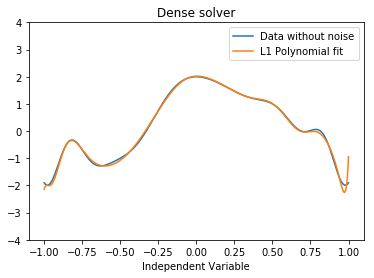

In [7]:
# plot the results
h = leg.legval(xs, coeffs_scipy_interiorpoint)
plt.plot(xs, f)
plt.plot(xs, h)
plt.ylim(-4, 4)
plt.xlabel("Independent Variable")
plt.legend(("Data without noise", "L1 Polynomial fit"))
plt.title("Dense solver");

The choice of algorithm really matters!

# Using NAG
Let's switch to NAG's linear programming solver.  First, `lp_solve` which uses a simplex method.

In [10]:
def lst_1norm_dense(A,b):
    # solves min ||b - Ax||_1 using a dense linear solver
    
    (m,n) = A.shape
    nvars = m+n
    ncons = 2*m
    
    # Linear constraints:
    # [-I   A  <=  b
    #  -I  -A] <= -b
    cons = np.zeros((ncons,nvars))
    cons[0:m,0:m] = -np.identity(m)
    cons[0:m,m:m+n] = A
    cons[m:2*m,0:m] = -np.identity(m)
    cons[m:2*m,m:m+n] = -A
    
    # objective function
    c = np.zeros(nvars)
    c[0:m] = 1.0
    
    # bounds on variables and linear constraints
    ub=np.zeros(nvars+ncons)
    lb=np.zeros(nvars+ncons)
    for i in range(0,m):
        lb[i]=0.0
        ub[i]=1.00E+20
    for i in range(m,m+n):
        lb[i]=-1.00E+20
        ub[i]=1.00E+20
    for i in range(m+n,m+n+m):
        ub[i]=b[i-m-n]
        lb[i]=-1.00E+20
    for i in range(m+n+m,m+n+m+m):
        ub[i]=-b[i-m-n-m]
        lb[i]=-1.00E+20
            
    # Initialize the solver
    istate = np.zeros(nvars+ncons).astype(np.int)
    x0 = np.zeros(nvars)
    comm = opt.nlp1_init('lp_solve')
    opt.lp_option_string('Optimality Tolerance = 1e-06',comm)
    
    # Solve the problem
    start = time.time()
    (istate,x,itera,obj,ax,clamda) = opt.lp_solve(ncons,cons,lb,ub,c,
                                                  istate,x0,comm)
    end = time.time()
    print("Time for NAG lp_solve: {} ".format(end - start))
    
    return x[m:2*m]  

In [13]:
# Let's try with a polynomial of degree 20
deg = 20
A = leg.legvander(xs, deg) # Vandermonde matrix
coeffs_NAG = lst_1norm_dense(A, f+errs)

Time for NAG lp_solve: 71.76199984550476 


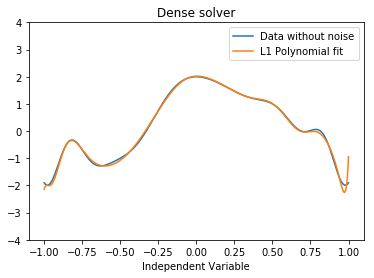

In [14]:
# plot the results
h = leg.legval(xs, coeffs_NAG)
plt.plot(xs, f)
plt.plot(xs, h)
plt.ylim(-4, 4)
plt.xlabel("Independent Variable")
plt.legend(("Data without noise", "L1 Polynomial fit"))
plt.title("Dense solver");

Much faster than the SciPy simplex method but several times slower than the new SciPy interior-point method.

NAG has interior-point too but it is aimed at large scale sparse problems. Can we still proceed to do better for this problem?

### Is the dense solver really the right approach?

When transforming the LP into the standard form, we saw that the constraint matrix is:
\begin{bmatrix}
-I & A\\
-I & -A\\
\end{bmatrix}
How dense is it actually?

In [15]:
nx = 600
degree = 20
for i in range(8):
    nfull = 2*nx*(nx+degree)
    na = 2*degree*nx + 2*nx
    print('number of samples        :', nx)
    print('constraint matrix density:', na/nfull*100,'%')
    print()
    nx += 200

number of samples        : 600
constraint matrix density: 3.387096774193549 %

number of samples        : 800
constraint matrix density: 2.5609756097560976 %

number of samples        : 1000
constraint matrix density: 2.0588235294117645 %

number of samples        : 1200
constraint matrix density: 1.7213114754098362 %

number of samples        : 1400
constraint matrix density: 1.4788732394366197 %

number of samples        : 1600
constraint matrix density: 1.2962962962962963 %

number of samples        : 1800
constraint matrix density: 1.153846153846154 %

number of samples        : 2000
constraint matrix density: 1.0396039603960396 %



#### Let's try the sparse solver!

In [16]:
def lst_1norm_sparse(A,b):
    # solves min ||b - Ax||_1 using a sparse linear solver
    
    # Problem dimensions
    (m,n) = A.shape
    nvars = m + n
    ncons = 2*m
    
    # Initialize the problem handle
    handle = opt.handle_init(nvars)
    
    # define the objective function
    c = np.zeros(nvars)
    c[0:m] = 1.0
    opt.handle_set_linobj(handle, c)
    
    # define the bounds on the varables
    lx = np.empty(nvars)
    ux = np.empty(nvars)
    for i in range(0,m):
        lx[i] = 0.0
        ux[i] = 1.00E+20
    for i in range(m,m+n):
        lx[i] = -1.00E+20
        ux[i] = 1.00E+20
    opt.handle_set_simplebounds(handle, lx, ux)
    
    # linear constraint matrix
    cons = np.zeros((ncons,nvars))
    cons[0:m,0:m] = -np.identity(m)
    cons[0:m,m:m+n] = A
    cons[m:2*m,0:m] = -np.identity(m)
    cons[m:2*m,m:m+n] = -A
    
    ub = np.empty(ncons)
    lb = np.empty(ncons)
    for i in range(m):
        ub[i] = b[i]
        ub[i+m] = -b[i]
        lb[i] = -1.00E+20
        lb[i+m] = -1.00E+20
    
    row, col = np.nonzero(cons)
    val = cons[row, col]
    row = row + 1
    col = col + 1
    opt.handle_set_linconstr(handle, lb, ub, irowb=row, icolb=col, b=val)
    
    # Deactivate solver output
    for option in ['Print Options = NO', 
                   'Print File = -1']:
        opt.handle_opt_set(handle, option)
        
    # Solve the problem
    start = time.time()  
    x,_,_,_ = opt.handle_solve_lp_ipm(handle)
    end = time.time()
    print("Time for NAG LPIPM: {} ".format(end - start))
    
    # Free the memory
    opt.handle_free(handle)
    
    return x[m:2*m]

In [18]:
coeffs_nag_sparse =lst_1norm_sparse(A,f+errs)

Time for NAG LPIPM: 0.3235499858856201 


Many times faster than anything we have seen so far!
Just as a check, let's plot the results again

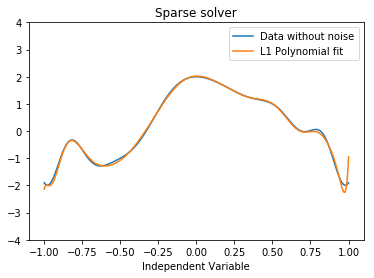

In [20]:
# plot the results
h = leg.legval(xs, coeffs_nag_sparse)
plt.plot(xs, f)
plt.plot(xs, h)
plt.ylim(-4, 4)
plt.xlabel("Independent Variable")
plt.legend(("Data without noise", "L1 Polynomial fit"))
plt.title("Sparse solver");

## A dedicated solver exists!

A lot of problems are common enough to have dedicated solvers developped. They should be faster and a lot easier to use than more general solvers. This is the case for the 1-norm minimization of an overdetermined linear system (fit.glin_l1sol):

In [21]:
A_ext = np.empty((nsamples+2, deg+3))
A_ext[0:nsamples,0:deg+1] = A
start = time.time()  
_, _, coeffs, _, _, _ = fit.glin_l1sol(A_ext, f+errs)
end = time.time()
print("Time for the dedicated solver: {} ".format(end - start))

Time for the dedicated solver: 0.028505563735961914 


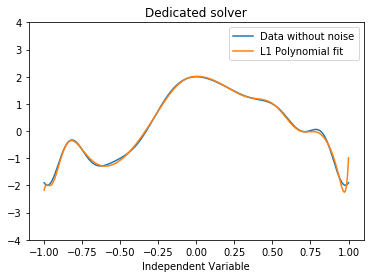

In [14]:
# plot the results
h = leg.legval(xs, coeffs[0:deg])
plt.plot(xs, f)
plt.plot(xs, h)
plt.ylim(-4, 4)
plt.xlabel("Independent Variable")
plt.legend(("Data without noise", "L1 Polynomial fit"))
plt.title("Dedicated solver");

## Conclusion

NAG's Linear Programming solvers are faster than the scipy equivalents for this problem.

Additionally, NAG's dedicated solver for this problem is even faster still.  The difference between the best and worst cases are several orders of magnitude!